In [1]:
from ccdc import io
from ccdc.descriptors import CrystalDescriptors
import pandas as pd
import numpy as np
import sklearn as sk
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import copy

In [2]:
current_directory = os.path.join(os.getcwd(), "cifs")
files_in_directory = os.listdir(current_directory)
cif_files = [os.path.join("cifs", file) for file in files_in_directory if file.endswith(".cif")]

In [3]:
import re
def parse_formula(formula: str):
    '''This takes a string in the form 'C48 H32 Co4 N8 O16' and converts it
       into a dict in the form {'C': 48, 'H': 32, ... }
    '''
    # Thanks chat gippity
    pattern = r'([A-Z][a-z]*)(\d*)'
    elements = re.findall(pattern, formula)
    parsed_formula = {}

    for element, count in elements:
        if count == '':
            count = 1
        else:
            count = int(count)
        # parsed_formula.append((element, count))
        parsed_formula[element] = count

    return parsed_formula

In [ ]:
formulas = []
unique_elements = set()
count = 0
for cif in cif_files:
    reader = io.EntryReader(cif)
    for mol in reader:
        crystal = mol.crystal
        for key in parse_formula(crystal.formula).keys():
            # unique_elements is a set, and sets don't allow duplicate elements, 
            # so we only have one copy of each element
            unique_elements.add(key)
            print(count)
            count += 1

2251


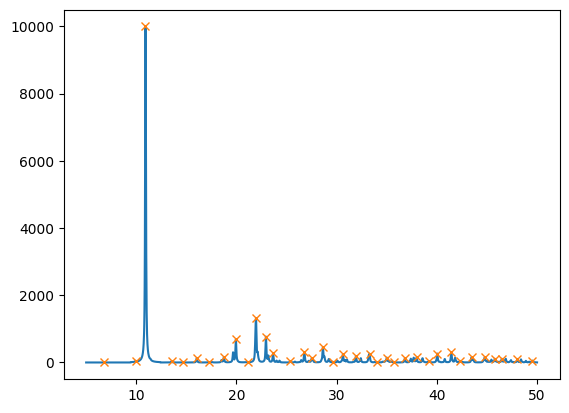

{'molecule_name': 'cifs/ABAVIJ_clean.cif', 'habit': None, 'disorder': 0, 'void_volume': 15.229166666666666, 'crystal_system': 'triclinic', 'calculated_density': 1.524916547326379, 'packing_coefficient': 0.6274021164021164, '2theta_0': 10.92, '2theta_1': 21.96, '2theta_2': 22.94, '2theta_3': 19.939999999999998, '2theta_4': 28.62, '2theta_5': 26.78, '2theta_6': 41.44, '2theta_7': 23.66, '2theta_8': 40.04, '2theta_9': 33.28}


NameError: name 'unique_elements' is not defined

In [28]:
import sys

mofs = []
count = 0
for cif in cif_files:
    reader = io.EntryReader(cif)
    for mol in reader:
        crystal = mol.crystal

        pattern     = CrystalDescriptors.PowderPattern.from_crystal(crystal)
        two_theta   = pattern.two_theta # x values in an xye file
        intensities = pattern.intensity # y values in an xye file
        zipped      = [(y, x) for x, y in zip(two_theta, intensities)]
        
        plt.plot(two_theta, intensities)
        peaks, props = find_peaks(intensities, distance=35)
        np_ints = np.array(intensities)
        np_thetas = np.array(two_theta)
        
        plotted_peaks = []
        # Each p is an index into the lists two_theta and intensities denoting there is a peak
        # there.
        for p in peaks:
            plotted_peaks.append((intensities[p], two_theta[p]))
        plotted_peaks.sort(reverse=True)
        y, x = zip(*plotted_peaks)
        plt.plot(x, y, 'x')
        print(len(intensities))      
        plt.show()
        XYE_POINTS = 10

        parsed_formula = parse_formula(crystal.formula)

        mof_data = {
            'molecule_name'      : cif,
            'habit'              : mol.habit,
            'disorder'           : int(crystal.has_disorder),
            'void_volume'        : crystal.void_volume(),
            'crystal_system'     : crystal.crystal_system,
            'calculated_density' : crystal.calculated_density,
            'packing_coefficient': crystal.packing_coefficient,
        }
        # Add the specified number of two theta peaks
        for x in range(XYE_POINTS):
            mof_data['2theta_' + str(x)] = plotted_peaks[x][-1]
        print(mof_data)
        # One hot encoding for elements in the MOF. 
        mof_data.update({key: parsed_formula.get(key, 0) for key in unique_elements})

        mofs.append(mof_data)

        print(count)
        count += 1

df = pd.DataFrame(mofs)
df.to_csv('mof_data.csv')


In [ ]:
print(unique_elements)
df